In [1]:
import matplotlib_inline
import matplotlib.dates
from IPython.display import set_matplotlib_formats
import requests
import os
import re
import sqlite3
import pandas as pd
from IPython.display import display, HTML
import datetime
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

import json
from pathlib import Path

## configs
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['savefig.format'] = 'svg'
plt.rcParams["figure.figsize"] = (15, 3)

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# plt.rcParams.keys()


## download config

In [2]:
## get config file from server and save locally
# r = requests.get('https://dev.rasal.de/Heizungsmessung/store/config.json', allow_redirects=True)
# open('data/config.json', 'wb').write(r.content)

## read local config.json and convert to list object
with open('data/config.json', 'r') as f:
  config = json.load(f)

## print config object
# print(json.dumps(config, indent=4, sort_keys=True))

## get some values
databaseFile = config['db_file']
ESPlist = config['ESP'].keys()

# print(ESPlist)


## download database

In [3]:
## download sqlite file & save locally
# r = requests.get('https://dev.rasal.de/Heizungsmessung/store/assets/db.sqlite', allow_redirects=True)
# open('data/db.sqlite', 'wb').write(r.content)

## connect to database
con = sqlite3.connect('data/db.sqlite')
# cur = con.cursor()
# for row in cur.execute('SELECT * FROM haus_one;'):
  # print(row)
# con.close()

# make dataframe of database
df_SQLite = pd.read_sql_query("SELECT * from haus_one", con)
con.close()

# save as csv file
df_SQLite.to_csv('data/data.csv')

# print(df_SQLite.head())


## resample data

In [4]:
## get the data from the SQLIte dataframe
df = df_SQLite
## make datetime index
df.index = pd.to_datetime(df['date'])
## remove some columns
df = df.drop('date', axis=1)
df = df.drop('id', axis=1)
## print original data
display(df)

## upsample to 1 minute
upsampled = df.resample('1Min').mean()
display(upsampled)



## interpolate values
interpolated = upsampled.interpolate(method='linear')


# save as csv file
interpolated.to_csv('data/data_interpolated.csv')


display(interpolated)


,temp_1,temp_2,hum_1,hum_2
date,,,,
2022-10-23 00:00:00,-0.09,45,40.41,23.01
2022-10-23 00:05:00,-0.18,45,33.17,21.11
2022-10-23 00:10:00,-0.27,44.99,30.05,19.35
2022-10-23 00:15:00,-0.36,44.98,31.81,17.83
2022-10-23 00:20:00,-0.45,44.98,38.03,16.59
...,...,...,...,...
2022-11-02 23:35:00,29.42,44.5,69.57,34.73
2022-11-02 23:40:00,29.33,44.45,65.19,35
2022-11-02 23:45:00,29.24,44.41,57.1,34.86


,temp_1,temp_2,hum_1,hum_2
date,,,,
2022-10-23 00:00:00,-0.09,45.00,40.41,23.01
2022-10-23 00:01:00,NaN,NaN,NaN,NaN
2022-10-23 00:02:00,NaN,NaN,NaN,NaN
2022-10-23 00:03:00,NaN,NaN,NaN,NaN
2022-10-23 00:04:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2022-11-02 23:51:00,NaN,NaN,NaN,NaN
2022-11-02 23:52:00,NaN,NaN,NaN,NaN
2022-11-02 23:53:00,NaN,NaN,NaN,NaN


,temp_1,temp_2,hum_1,hum_2
date,,,,
2022-10-23 00:00:00,-0.090,45.00,40.410,23.010
2022-10-23 00:01:00,-0.108,45.00,38.962,22.630
2022-10-23 00:02:00,-0.126,45.00,37.514,22.250
2022-10-23 00:03:00,-0.144,45.00,36.066,21.870
2022-10-23 00:04:00,-0.162,45.00,34.618,21.490
...,...,...,...,...
2022-11-02 23:51:00,29.142,44.35,45.428,34.148
2022-11-02 23:52:00,29.124,44.34,43.596,33.966
2022-11-02 23:53:00,29.106,44.33,41.764,33.784


## plot

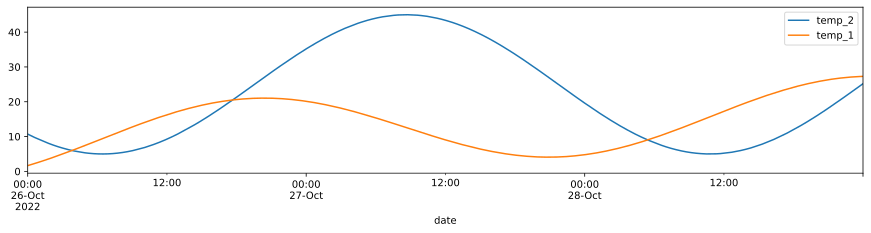

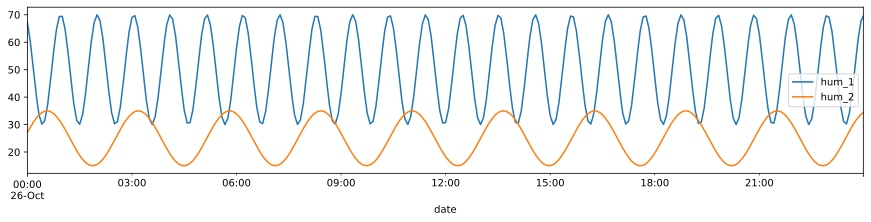

In [5]:

von = "2022-10-26"
bis = "2022-10-28"

ax = plt.gca()
interpolated[von:bis].plot(y='temp_2', kind='line', ax=ax)
interpolated[von:bis].plot(y='temp_1', kind='line', ax=ax)
plt.show()

von = "2022-10-26"
bis = "2022-10-26"
ax = plt.gca()
interpolated[von:bis].plot(y='hum_1', kind='line', ax=ax)
interpolated[von:bis].plot(y='hum_2', kind='line', ax=ax)
plt.show()


In [6]:
## https://plotly.com/python/line-charts/
fig = go.Figure()
fig.add_trace(go.Scatter(x=interpolated.index,
              y=interpolated.hum_1, mode='lines', name='Hum1' , line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=interpolated.index,
              y=interpolated.hum_2, mode='lines', name='Hum2',  line=dict(color='royalblue', width=2)))
 
fig.show()
